In [82]:
# pandas
import pandas as pd
from pandas import Series,DataFrame
from datetime import datetime as datetime
import re as re
# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')
pd.options.mode.chained_assignment = None  # default='warn'

In [83]:
df = pd.read_csv('Bookings per stashpoint prediciton.csv')  
df['activated'] = pd.to_datetime(df['activated'] , errors='coerce')

# Filter to only include stashpoints in the UK (country == 'GBR')
df = df[df['country'] == 'GBR'].copy()

df.head()

,stashpoint_id,bookings_90d,business_name,country,type,capacity,activated,sps_within_500m,units_supply_within_500m,review_count_90d,avg_review_rating_90d,searches_last_90
3,21ee810bc764,2,Foodwise Express,GBR,convenience_store,50,2024-11-06,24,1355,0,NaN,7958
5,6f169b288d15,3,Foodwise Local,GBR,convenience_store,10,2025-05-29,24,1395,0,NaN,7953
9,08b673bc5584,113,Europa House Hotel,GBR,hotel,200,2023-07-26,23,1156,4,4.75,4388
11,5c806eaca40c,11,Sonic Paddington Souvenirs,GBR,luggage_storage_shop,100,2025-03-05,23,1255,0,NaN,7925
13,b612231f182c,3,Mail Boxes Etc,GBR,postal_shop,50,2020-05-25,23,1305,0,NaN,7946


In [84]:
print(df.columns.tolist()) 

['stashpoint_id', 'bookings_90d', 'business_name', 'country', 'type', 'capacity', 'activated', 'sps_within_500m', 'units_supply_within_500m', 'review_count_90d', 'avg_review_rating_90d', 'searches_last_90']


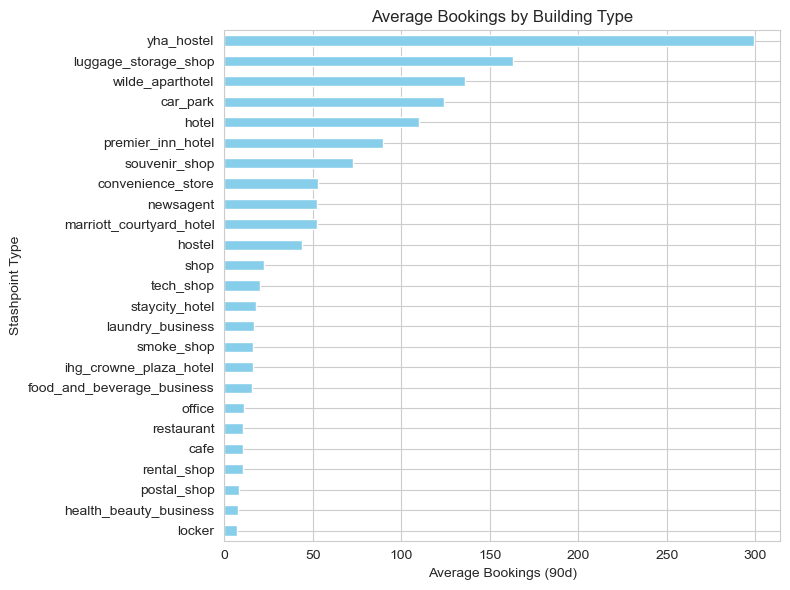

In [85]:
avg_bookings_by_type = df.groupby('type')['bookings_90d'].agg(['count', 'mean', 'median']).sort_values('mean', ascending=False)
#print(avg_bookings_by_type)

avg_bookings_by_type['mean'].plot(kind='barh', figsize=(8, 6), color='skyblue')
plt.xlabel('Average Bookings (90d)')
plt.ylabel('Stashpoint Type')
plt.title('Average Bookings by Building Type')
plt.gca().invert_yaxis()  # Highest on top
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [87]:
# list of unique locations type 
#print(df['type'].value_counts())
# Group some of them 

type_mapping = {
    # Hospitality
    'hotel': 'hospitality',
    'hostel': 'hospitality',
    'premier_inn_hotel': 'hospitality',
    'staycity_hotel': 'hospitality',
    'wilde_aparthotel': 'hospitality',
    'yha_hostel': 'hospitality',
    'marriott_courtyard_hotel': 'hospitality',
    'concordia_boutique_hotel': 'hospitality',
    'sofitel_hotel': 'hospitality',
    'ihg_crowne_plaza_hotel': 'hospitality',

    # Retail
    'shop': 'retail',
    'convenience_store': 'retail',
    'tech_shop': 'retail',
    'postal_shop': 'retail',
    'luggage_storage_shop': 'retail',
    'rental_shop': 'retail',
    'souvenir_shop': 'retail',
    'newsagent': 'retail',
    'smoke_shop': 'retail',

    # Food & Beverage
    'food_and_beverage_business': 'food',
    'restaurant': 'food',
    'cafe': 'food',

    # Services
    'office': 'services',
    'health_beauty_business': 'services',
    'laundry_business': 'services',

    # Utility
    'car_park': 'utility',

    # Locker
    'locker': 'locker'
}

# Apply grouping
df['type_grouped'] = df['type'].map(type_mapping).fillna('other')
print(df['type_grouped'].value_counts())

type_grouped
locker         952
retail         380
hospitality    378
services       120
food            99
utility          1
Name: count, dtype: int64


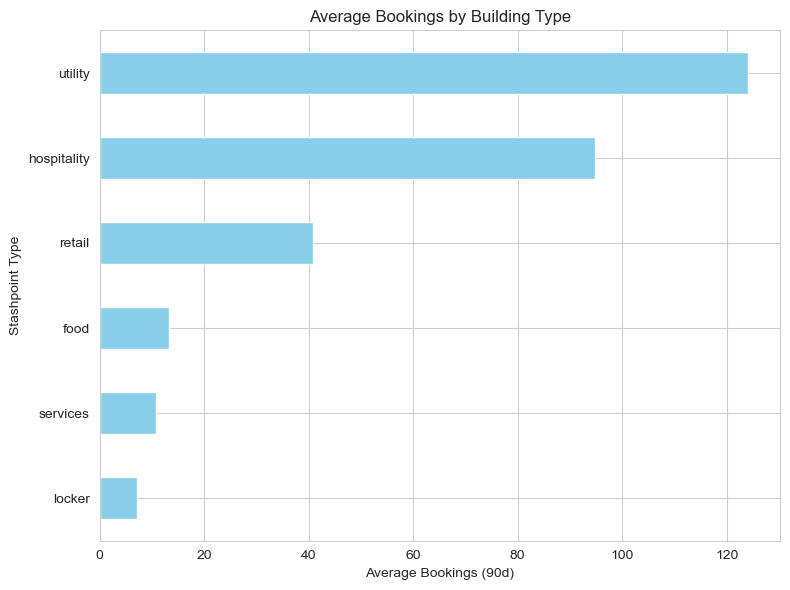

In [88]:
avg_bookings_by_type = df.groupby('type_grouped')['bookings_90d'].agg(['count', 'mean', 'median']).sort_values('mean', ascending=False)
#print(avg_bookings_by_type)

avg_bookings_by_type['mean'].plot(kind='barh', figsize=(8, 6), color='skyblue')
plt.xlabel('Average Bookings (90d)')
plt.ylabel('Stashpoint Type')
plt.title('Average Bookings by Building Type')
plt.gca().invert_yaxis()  # Highest on top
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [43]:
# One-hot encode 'type_grouped' and drop the original column
df = pd.get_dummies(df, columns=['type_grouped'], prefix='type', drop_first=True)

In [44]:
# Drop non needed 
df.drop(['country', 'type'], axis=1, inplace=True)

In [45]:
## Additional variables 

today = pd.Timestamp.today()
df['age_in_days'] = (today - df['activated']).dt.days

# Competition density (stashpoints per unit) (removed as v weak correlation) 
df['competition_density'] = df['sps_within_500m'] / (df['units_supply_within_500m'] + 1)

# Search to supply ratio
df['search_to_supply_ratio'] = df['searches_last_90'] / (df['units_supply_within_500m'] + 1)

In [61]:
# Dealing with too many missings

missing_pct = df.isnull().mean().sort_values(ascending=False)
#print(missing_pct)

zero_pct = (df == 0).mean(numeric_only=True).sort_values(ascending=False)
#print(zero_pct)


In [47]:
threshold_missing = 0.3 # Remove if > 30% missing 
threshold_zero = 0.8 # remove if > 80% are 0

cols_to_drop = missing_pct[missing_pct > threshold_missing].index.tolist()
cols_to_drop += zero_pct[zero_pct > threshold_zero].index.tolist()
cols_to_drop = list(set(cols_to_drop))  # remove duplicates

print("Columns to consider dropping:", cols_to_drop)

Columns to consider dropping: ['type_utility', 'review_count_90d', 'type_retail', 'type_services', 'type_hospitality', 'avg_review_rating_90d']


In [48]:
df.drop(['review_count_90d', 'avg_review_rating_90d'], axis=1, inplace=True)

In [49]:
df.head() 

,stashpoint_id,bookings_90d,business_name,capacity,activated,sps_within_500m,units_supply_within_500m,searches_last_90,type_hospitality,type_locker,type_retail,type_services,type_utility,age_in_days,competition_density,search_to_supply_ratio
3,21ee810bc764,2,Foodwise Express,50,2024-11-06,24,1355,7958,False,False,True,False,False,243,0.017699,5.868732
5,6f169b288d15,3,Foodwise Local,10,2025-05-29,24,1395,7953,False,False,True,False,False,39,0.017192,5.696991
9,08b673bc5584,113,Europa House Hotel,200,2023-07-26,23,1156,4388,True,False,False,False,False,712,0.019879,3.792567
11,5c806eaca40c,11,Sonic Paddington Souvenirs,100,2025-03-05,23,1255,7925,False,False,True,False,False,124,0.018312,6.309713
13,b612231f182c,3,Mail Boxes Etc,50,2020-05-25,23,1305,7946,False,False,True,False,False,1869,0.017611,6.084227


In [50]:
#Run correlation analysis 

In [57]:
import matplotlib.pyplot as plt

# Compute correlations with target
correlations = df.corr(numeric_only=True)['bookings_90d'].drop('bookings_90d').sort_values()
correlations
# Plot
#plt.figure(figsize=(8, 6))
#correlations.plot(kind='barh')
#plt.title('Feature Correlation with Bookings (Pearson)')
#plt.xlabel('Correlation Coefficient')
#plt.grid(True)
#plt.tight_layout()
#plt.show()

type_locker                -0.201632
type_services              -0.044562
competition_density        -0.035142
type_utility                0.017603
type_retail                 0.038647
search_to_supply_ratio      0.187307
age_in_days                 0.213924
capacity                    0.215565
type_hospitality            0.261021
sps_within_500m             0.298497
units_supply_within_500m    0.334850
searches_last_90            0.488269
Name: bookings_90d, dtype: float64

#### Summary of Correlation Strengths

In [62]:
# searches_last_90	0.49	Strongest linear relationship — keep.
# units_supply_within_500m	0.33	Moderate — keep.
# sps_within_500m	0.30	Moderate — keep.
# type_hospitality	0.26	Meaningful categorical feature — keep.
# capacity	0.22	Reasonable — keep.
# age_in_days	0.21	Time since activation — useful.
# search_to_supply_ratio	0.19	Demand-supply proxy — useful.
# type_retail	0.04	Weak, may keep depending on importance in model.
# type_utility	0.02	Negligible correlation — consider dropping.
# competition_density	-0.04	Very weak negative — consider dropping.
# type_services	-0.04	Also weak — consider dropping.
# type_locker	-0.20	Slightly negative, may indicate niche behavior — optional.

#Correlation is a univariate linear relationship

#correlation = -0.035  # Very weak
#This says: across the dataset, competition_density alone has almost no direct linear relationship with bookings_90d.

#However, this doesn't account for its interaction or collinearity with other variables (like sps_within_500m or units_supply_within_500m).


In [63]:
# Run the Ridge regression coefficients to confirm whether weakly correlated variables actually have low impact in the model. 

In [59]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Select features and target 
X = df.drop(columns=['stashpoint_id', 'bookings_90d', 'activated'], errors='ignore')
X = X.select_dtypes(include=['number'])  # Keep only numeric columns
y = df['bookings_90d']
# Standardize numeric features
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

# Split into train/test (optional for now)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit Ridge regression
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# Get coefficients
coefficients_ridge = pd.Series(model.coef_, index=X.columns).sort_values()
coefficients_ridge
# Plot
#plt.figure(figsize=(8, 6))
#coefficients.plot(kind='barh')
#plt.title('Feature Importance via Ridge Regression')
#plt.xlabel('Coefficient Value')
#plt.grid(True)
#plt.tight_layout()
#plt.show()

units_supply_within_500m    -1.360777
competition_density         -0.687881
sps_within_500m              0.713616
age_in_days                  8.254867
search_to_supply_ratio       8.766311
capacity                    10.538868
searches_last_90            56.193497
dtype: float64

In [60]:
###Feature	Coefficient	Interpretation
# Positive: 
#searches_last_90	56.19	🔥 Strongest driver — more searches nearby = more bookings.
#capacity	10.54	Higher capacity → more bookings.
#search_to_supply_ratio	8.77	Demand relative to supply matters.
#age_in_days	8.25	Older stashpoints tend to get more bookings (established trust).
#sps_within_500m	0.71	Slight positive influence — competition may attract attention.

# Negative: 
#competition_density	-0.69	Too much competition per unit might hurt.
#units_supply_within_500m	-1.36	Nearby excess supply may dilute demand.

SyntaxError: invalid syntax (1085358035.py, line 1)

competition_density Ridge coefficient = -0.688  # Moderate negative
This means: when holding all other variables constant, a 1 standard deviation increase in competition_density is associated with a decrease in bookings.

The Ridge model penalizes correlated predictors (like sps_within_500m), so its effectively saying:
“Given that sps_within_500m is already included and positively important, the remaining unique effect of competition_density is negative.”

Why sps_within_500m is positive but competition_density is negative? 
This is the core insight:
sps_within_500m: raw count of competitors nearby — positive effect → suggests a higher-density area that attracts users (like a busy train station).
competition_density = sps / (units + 1): normalizes competition per unit of supply → if a place has many stashpoints but little supply, its hyper-competitive — this makes sense to negatively affect your stashpoint.

More competition is OK when there’s ample demand and supply, but bad when it’s too tight?


In [ ]:
# Keep competition_density for now, especially in regularized models like Ridge or Lasso.
# Monitor Variance Inflation Factor (VIF) if you plan to fit a regular linear regression (to diagnose multicollinearity).
# Consider trying models like Random Forest, which are less sensitive to collinearity and can show importance more robustly.

In [64]:
# Let's try a Random Forest 
# handles non-linearities.
#robust to multicollinearity. 

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Prepare features and target
X = df.drop(columns=['stashpoint_id', 'bookings_90d', 'activated'], errors='ignore')
X = X.select_dtypes(include=['number'])  # keep numeric only
y = df['bookings_90d']

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Fit Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 4. Predict and evaluate
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Random Forest R²: {r2:.3f}')
print(f'Random Forest RMSE: {rmse:.2f}')

Random Forest R²: 0.436
Random Forest RMSE: 80.51


R² = 0.436 →  model explains ~44% of the variance in bookings.

RMSE = 80.51 → On average, your predictions are off by ~80 bookings over 90 days.



In [67]:
# Feature importance (Feature rankings: Based on actual contribution to model accuracy, not just linear effect) 
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values()
importances

# Plot
#plt.figure(figsize=(8, 6))
#importances.plot(kind='barh')
#plt.title('Feature Importance (Random Forest)')
#plt.xlabel('Importance Score')
#plt.tight_layout()
#plt.grid(True)
#plt.show()

competition_density         0.062658
units_supply_within_500m    0.067322
capacity                    0.085603
sps_within_500m             0.098018
age_in_days                 0.099447
search_to_supply_ratio      0.136782
searches_last_90            0.450170
dtype: float64

### Feature Importance (Random Forest)

In [ ]:
# searches_last_90	0.45	🔥 Most influential — demand signal is key.
# search_to_supply_ratio	0.14	High demand per supply = more bookings.
# age_in_days	0.10	Older hosts get more bookings — likely more visibility/trust.
# sps_within_500m	0.10	More nearby stashpoints = more visibility or clustering benefits.
# capacity	0.09	More space = more opportunity to book.
# units_supply_within_500m	0.07	Local supply matters, but less so than demand.
# competition_density	0.06	✅ Still contributes — not a top feature, but not noise.

In [71]:
# The case of competition density: 
# competition_density should be kept — it has meaningful but secondary predictive value.
# Its importance > 0.05, which is often used as a soft threshold in Random Forest to separate signal from noise.
# Its negative sign in Ridge and modest importance in RF suggest it's a refining feature, not a driver — helpful for adjusting predictions downward when competition is fierce.


## XGBoost

In [ ]:
# XGBoost is often a step up in performance compared to Random Forest, especially when:
# You have structured/tabular data (like yours).
# Relationships are non-linear.
# You want regularization, better handling of outliers, and finer boosting.

## NOT FOUND IN MY PACKAGE 
# let's try transformation of target as v skwed &  Random Forest can’t easily capture extreme ranges 
#Makes the target more normally distributed.
#Reduces the effect of outliers.
#Improves performance for models like Random Forest, which are sensitive to target distribution.

## Linear reg

In [78]:
#1. Nonlinear Relationships
#From your data:
#searches_last_90: very strong positive impact (correlation: 0.49, RF importance: 0.45).
#search_to_supply_ratio and age_in_days: moderate impact in RF (but much smaller correlation).
#This mismatch between correlation and importance suggests nonlinear effects (e.g., thresholds, diminishing returns).
#
#👉 Conclusion:
#Yes, your data likely has nonlinearity, especially for features like:
#
#search_to_supply_ratio: might plateau.
#age_in_days: could have diminishing returns.
#competition_density: has complex effects not captured by linear correlation.
#Linear regression may underfit or oversimplify these patterns.
#
#2. Multicollinearity
#You’ve created:
#competition_density = sps_within_500m / (units_supply_within_500m + 1)
#And also included:
#sps_within_500m
#units_supply_within_500m
#This creates strong multicollinearity between those three variables.
#
#👉 Conclusion:
#Yes, your data does have multicollinearity — especially from engineered variables. This:
#Inflates standard errors in coefficients.
#Makes LinearRegression unstable.
#Is exactly what Ridge or Lasso is designed to handle.

## WE HAVE TRIED HERE LINEAR REGRESSION (with non-eng variables, as well as log(Y). Results not great. 
### WE CONTINUE HERE USING RIDGE 

SyntaxError: invalid character '👉' (U+1F449) (985091975.py, line 9)

In [79]:
# Transform target: log(1 + bookings)
#y_log = np.log1p(df['bookings_90d'])

In [76]:
# refit randow forest

# Features (same as before)
#X = df.drop(columns=['stashpoint_id', 'bookings_90d', 'activated'], errors='ignore')
#X = X.select_dtypes(include='number')
#
## Train/test split
#X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
#
## Fit model
#rf = RandomForestRegressor(n_estimators=100, random_state=42)
#rf.fit(X_train, y_train)
#
## Predict and inverse transform
#y_pred_log = rf.predict(X_test)
#y_pred = np.expm1(y_pred_log)  # Reverse the log1p
#
## Actual target (unlogged)
#y_true = np.expm1(y_test)
#
## Evaluate
#r2 = r2_score(y_true, y_pred)
#rmse = np.sqrt(mean_squared_error(y_true, y_pred))
#
#print(f'Random Forest (log-transformed target) R²: {r2:.3f}')
#print(f'Random Forest (log-transformed target) RMSE: {rmse:.2f}')

Random Forest (log-transformed target) R²: 0.318
Random Forest (log-transformed target) RMSE: 88.55


In [77]:
## REsults : 
# Random Forest (log-transformed target) R²: 0.318
# Random Forest (log-transformed target) RMSE: 88.55

SyntaxError: invalid syntax (2191003434.py, line 2)

In [ ]:
#The original target wasn’t skewed enough to benefit from log transformation.
# keep original target 

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
# Imputer for missing values
imputer = SimpleImputer(strategy='median')  # Median is robust to outliers
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Now scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Linear Model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_preds = lr.predict(X_test_scaled)

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)  # Tree-based models don't need scaling
rf_preds = rf.predict(X_test)

# Evaluation
print("Linear Regression:")
print("RMSE:", mean_squared_error(y_test, lr_preds, squared=False))
print("R²:", r2_score(y_test, lr_preds))

print("\nRandom Forest:")
print("RMSE:", mean_squared_error(y_test, rf_preds, squared=False))
print("R²:", r2_score(y_test, rf_preds))

Linear Regression:
RMSE: 30.404117219999165
R²: 0.817154412933356

Random Forest:
RMSE: 39.332146034609075
R²: 0.69400454727251


C:\Users\brethm01\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\brethm01\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [24]:
# Factor analysis 

In [26]:
from sklearn.preprocessing import StandardScaler

# Keep only relevant continuous variables (you can adjust this)
fa_features = [
    'capacity',
    'sps_within_500m',
    'units_supply_within_500m',
    'review_count_90d',
    'avg_review_rating_90d',
    'searches_last_90',
    'age_in_days',
    'competition_density',
    'search_to_supply_ratio' 
]

# Drop rows with NaNs
fa_data = df[fa_features].dropna()

# Standardize
scaler = StandardScaler()
fa_data_scaled = scaler.fit_transform(fa_data)

In [27]:
from sklearn.decomposition import FactorAnalysis

# Try with 2 or 3 factors to start
fa = FactorAnalysis(n_components=3, random_state=42)
factors = fa.fit_transform(fa_data_scaled)

# Loadings (how variables relate to each factor)
loadings = pd.DataFrame(fa.components_.T, index=fa_features, columns=[f'Factor{i+1}' for i in range(3)])
print(loadings)

                           Factor1   Factor2   Factor3
capacity                  0.123665  0.007145  0.012313
sps_within_500m           0.970945 -0.061401  0.020914
units_supply_within_500m  0.844275 -0.055578  0.039333
review_count_90d          0.296839  0.805486 -0.134970
avg_review_rating_90d    -0.008599  0.147377 -0.063632
searches_last_90          0.556322  0.411110 -0.049974
age_in_days              -0.005759  0.213596 -0.046626
competition_density      -0.144068  0.040231  0.274920
search_to_supply_ratio   -0.154411  0.335408  0.662601


In [ ]:
#Factor	 Strong Loadings
#F1	Local Density & Demand: sps_within_500m, units_supply_within_500m, searches_last_90
#F2	Reputation & Engagement:	review_count_90d, searches_last_90
#F3	Demand Efficiency:	search_to_supply_ratio

In [28]:
# `factors` was already computed as:
# factors = fa.fit_transform(fa_data_scaled)

# Put it into a DataFrame for clarity
factor_scores = pd.DataFrame(factors, columns=['Factor1', 'Factor2', 'Factor3'])

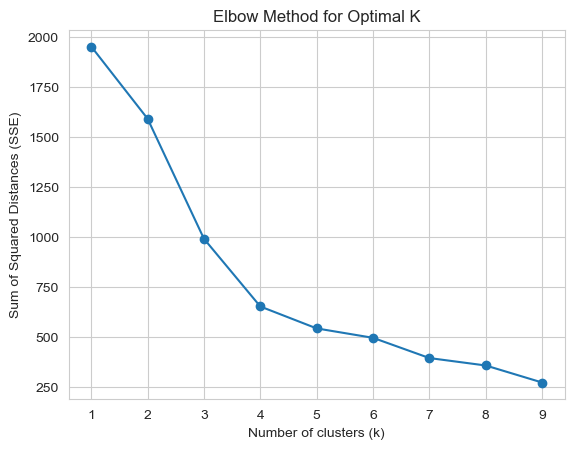

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: find best K using elbow method
sse = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(factor_scores)
    sse.append(km.inertia_)

plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

In [30]:
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(factor_scores)

# Add to original data
df_clustered = fa_data.copy()
df_clustered['Cluster'] = cluster_labels

In [33]:
# View mean values per cluster
cluster_summary = df_clustered.groupby('Cluster').mean()
print(cluster_summary.round(2))   

         capacity  sps_within_500m  units_supply_within_500m  \
Cluster                                                        
0           52.53            11.54                    617.94   
1           38.14             2.48                     85.26   
2           65.53             7.90                    391.55   
3           40.45             0.45                      0.00   

         review_count_90d  avg_review_rating_90d  searches_last_90  \
Cluster                                                              
0                    2.65                   4.25           3266.80   
1                    2.08                   4.43            606.61   
2                   18.73                   4.76           8868.80   
3                    6.64                   4.57           1467.36   

         age_in_days  competition_density  search_to_supply_ratio  
Cluster                                                            
0             765.58                 0.02                 

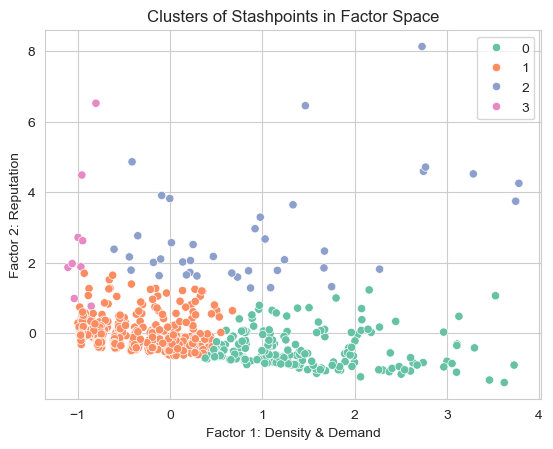

In [34]:
sns.scatterplot(
    x='Factor1', y='Factor2',
    hue=cluster_labels,
    data=factor_scores,
    palette='Set2'
)
plt.title('Clusters of Stashpoints in Factor Space')
plt.xlabel('Factor 1: Density & Demand')
plt.ylabel('Factor 2: Reputation')
plt.grid(True)
plt.show()